# Построение и обучение моделей в TensorFlow

В TensorFlow доступно два подхода к построению моделей:
- использование низкоуровневого АПИ TensorFlow и класса Module;
- использование высокоуровневого АПИ Keras.

Рекомендуется использовать именно Keras, поскольку он избавляет разработчиков от забот написания цикла обучения, тестирование модели, сохранения и прочего. Однако рассмотрено будет оба подхода. В данной лекции фокус будет на использовании низкоуровневого API. Вручную будут написаны слои модели, функция ошибки и функция тестирования, а также цикл обучения. 

Высокоуровневый АПИ нередко применяется вкупе с низкоуровневым, поэтому вся информация в этой лекции крайне полезна для случаев, когда Keras не удовлетворяет всем потребностям и есть необходимость написать что-то своё.

Низкоуровневый и высокоуровневый АПИ будут рассмотрены на примере задачи классификации изображений цифр из набора **Mnist**.

# 1. Низкоуровневый АПИ + tf.Module

## 1.0 Mnist Dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
y_train.dtype

dtype('uint8')

Датасет Mnist представляет собой набор черно-белых картинок рукописных цифр (0..9) размером 28x28 пикселей.

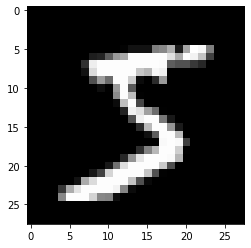

In [5]:
plt.imshow(x_train[0], cmap='gray')

In [6]:
# Нормализуем данные
mean, std = np.mean(x_train), np.std(x_train)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

x_train = x_train.reshape(-1, 28 * 28).astype('float32')
x_test = x_test.reshape(-1, 28 * 28).astype('float32')

# 1.1 tf.Module

Все (практически) модели состоят из слоёв - отдельных компонентов, производящих конкретную операцию: матричное умножение, свёртка, применение нелинейной функции и т.д. Такой подход к построению моделей позволяет делать код компактным, читабельным и легко поддерживаемым (для справки, раньше так не делали). 

Базовым классом для создания слоя (модуля) модели является класс Module. Напишем слой линейного преобразования - полносвязный слой. Он умножает входной вектор на матрицу и прибавляет байес (другой вектор).

In [7]:
class Linear(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        # В случае с tf.Module вызывать конструктор родительского класса обязательно! 
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=1./np.sqrt(in_d), dtype='float32')
        self.w = tf.Variable(w, name='linear')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float32') * 0.1, name='bias')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

In [8]:
layer = Linear(10, 10)

In [9]:
# Тестовый запуск
x = tf.random.normal(shape=[1, 10])
print(x)
out = layer(x)
print(np.std(out))

tf.Tensor(
[[-0.7744995   1.8459216   0.27362576 -0.5709607  -0.20550066  0.5763507
   1.1164591   0.30397055  0.5187615  -1.6810396 ]], shape=(1, 10), dtype=float32)
0.5604569


Класс tf.Module обладает целым рядом функций, упрощающих создание и обучение моделей:
1. Коллекционирование весов модели (tf.Variable).
2. Коллекционирование модулей.
3. Возможность сохранения весов (будет показано далее).

In [10]:
# Веса
print(layer.variables[0].name)
print(layer.variables[1].name)

bias:0
linear:0


In [11]:
# Модули
layer.submodules

()

Для иллюстрации второй функции напишем слой, совмещающий в себе слой Linear и функцию активации ReLU.

In [12]:
class LinearReLU(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        # in_d - input dimensionality
        # out_d - output dimensionality
        super().__init__(name=name)
        linear_name = None
        if name is not None:
            linear_name = name + '_linear'
        self.linear = Linear(in_d, out_d, name=linear_name)
    
    def __call__(self, x):
        x = self.linear(x)
        return tf.nn.relu(x)

In [13]:
linear_relu = LinearReLU(10, 10)

In [14]:
# Веса
print(linear_relu.variables[0].name)
print(linear_relu.variables[1].name)

bias:0
linear:0


In [15]:
# Модули
linear_relu.submodules
# Объект `linear_relu` "запомнил" модуль, что находится внутри него.

(<__main__.Linear at 0x7f508e4f8280>,)

Построим теперь двухслойную полносвязную нейронную сеть с использованием написанных слоёв.

In [16]:
class NN(tf.Module):
    def __init__(self, in_d, dim=256, n_classes=10, name='neural_network'):
        super().__init__(name=name)
        self.input_layer = LinearReLU(in_d, dim, name='input')
        self.classification_head = Linear(dim, n_classes, name='head')
    
    def __call__(self, x):
        x = self.input_layer(x)
        x = self.classification_head(x)
        return tf.nn.softmax(x)

In [17]:
model = NN(in_d=28 * 28)

In [18]:
model(x_train[:1])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.28278467, 0.07786416, 0.03850088, 0.0468896 , 0.08967251,
        0.09703497, 0.07453809, 0.03147001, 0.08553318, 0.17571196]],
      dtype=float32)>

## 1.2 Обучение

Нейронные сети обучаются при помощи алгоритма градиентного спуска. Определяется функция ошибки, которая далее минимизируется посредством вычитания из весов нейронной сети их градиента. Однако вручную реализовывать данный алгоритм не придётся, поскольку TensorFlow реализует его за нас. На данном этапе заботой разработчика является определение функции ошибки, написание цикла обучения и функции тестирования модели.

Функция ошибки - некая скалярная дифференцируемая функция, что является мерой ошибки ответа сети. Посредством алгоритма градиентного спуска веса нейронной сети изменяются таким образом, чтобы минимизировать значение функции ошибки.

В цикле обучения происходит непосредственно обучение. На каждой итерации производится один градиентный шаг (одна итерация изменения весов для минимизации функции ошибки) и каждые N итераций проходит тестирование модели.

Тестирование модели по ходу обучения необходимо для того, чтобы регулировать гиперпараметры модели (и не только), дабы добиться наивысшей точности.

In [19]:
# Для начала напишем функцию тестирования модели

In [20]:
!pip install tqdm

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 1.2.1 Функции обучения и тестирования

In [21]:
# Позволяет видеть виджет прогресса цикла.
from tqdm import tqdm


def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)


def evaluate(model, x_test, y_test, batch_size=128):
    """
    Функция тестирования модели.
    """ 
    n_batches = x_test.shape[0] // batch_size
    n_remains = x_test.shape[0] - n_batches * batch_size
    
    y_preds = []
    for i in tqdm(range(n_batches)):
        x_batch = x_test[i*batch_size:(i+1)*batch_size]
        # preds - [batch_size, n_classes]
        preds = model(x_batch)
        # preds - [batch_size]
        preds = tf.argmax(preds, axis=-1)  # Находит индекс наибольшего элемента
        y_preds.append(preds)
    
    if n_remains != 0:
        x_batch = x_test[-n_remains:]
        preds = model(x_batch)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
    
    y_preds = tf.concat(y_preds, axis=0)
    return accuracy(y_test, y_preds).numpy()

In [22]:
acc = evaluate(model, x_test, y_test)
print('Точность', round(acc * 100, 2), '%')

100%|██████████| 78/78 [00:00<00:00, 636.88it/s]

Точность 6.98 %


Точность крайне низкая, что в целом ожидаемо, поскольку модель еще не обучена. Напишем теперь функцию, что производит одну обучающую итерацию (один обучающий шаг).

In [23]:
N_CLASSES = 10


def cross_entropy(labels, preds):
    """
    Вычисляет значение перекрестной энтропии (Cross-Entropy) - классическая
    функция ошибки, используемая в задаче классификации.
    """
    # Прибавление константы для улучшения численной стабильности.
    # Если не прибавлять маленькое чисто, то возможно появление nan
    log = tf.math.log(preds + 1e-4)
    onehot = tf.one_hot(labels, depth=N_CLASSES, dtype='float32')
    log = log * onehot
    log = tf.reduce_sum(log, axis=-1)
    return -tf.reduce_mean(log)


def train_step(model, data, optim):
    """
    Функция, производящая один обучающий шаг.
    """
    with tf.GradientTape() as tape:
        # "Прогон" данных через модель и вычисление значения функции ошибки
        x, y = data
        preds = model(x)
        loss = cross_entropy( y, preds)
    # Вычисление градиентов
    grads = tape.gradient(loss, model.trainable_variables)
    # Применение градиентов к весам
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss

Выше используется функция ошибки Cross Entropy (перекрёстная энтропия), что является стандартом для задачи классификации. Функция `train_step` содержит в себе стандартный код для всех циклов обучения:
1. прогонка данных через модель;
2. вычисление значения функции ошибки;
3. вычисление градиентов весов;
4. применение градиентов к весам.

### 1.2.2 Цикл обучения модели

In [24]:
# Гиперпараметры обучения

optim = tf.optimizers.Adam(learning_rate=0.005)

EPOCHS = 5
BATCH_SIZE = 256

n_batches = x_train.shape[0] // BATCH_SIZE
print_period = 100

- Эпоха (`EPOCHS`) - означает один проход по всему датасету. 
- Размер батча (`BATCH_SIZE`) - группа экземпляров (картинок) данных, что подаётся на вход модели. Вместо того, чтобы в модель подавать лишь один экземпляр, обычно подаётся несколько экземпляров, что и называют батчем. Связано это с тем, что градиент, вычисляемый по одному экземпляру, очень шумный, из-за чего обучение проходит гораздо медленнее. Такой подход также не позволяет эффективно утилизировать вычислители (графический процессор). Поэтому обычно считают градиент по батчу, усредняя его.
- Оптимизатор (`optim`) - алгоритм градиентного спуска или его модификация. Поскольку классический градиентный спуск сходится довольно медленно, было разработано множество модификаций (например, Adam). Они сходятся существенно быстрее, позволяя добиться высокой точности при меньших затратах времени. Заметка: за классический градиентный спуск отвечает оптимизатор `tf.optimizers.SGD`.

In [25]:
# Цикл обучения

take_data = lambda i: (x_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE], y_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE])

for epoch in range(EPOCHS):
    # Перемешивание данных. Очень часто это позволяет повысить точность модели.
    # Рекомендуется перемешивать данные всегда!
    indices = np.arange(0, len(x_train), 1)
    np.random.shuffle(indices)
    x_train, y_train = x_train[indices], y_train[indices]
    for i in tqdm(range(n_batches)):
        data = take_data(i)
        loss = train_step(model, data, optim)
        
        if i % print_period == 0:
            print('Epoch:', epoch, 'Iteration:', i, 'Loss:', loss.numpy())
    
    print('Тестирование модели...')
    acc = evaluate(model, x_test, y_test)
    print('Epoch:', epoch, 'Accuracy:', acc)

  0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.748917


 49%|████▉     | 115/234 [00:01<00:01, 109.24it/s]

Epoch: 0 Iteration: 100 Loss: 0.16372028


 94%|█████████▍| 221/234 [00:02<00:00, 112.27it/s]

Epoch: 0 Iteration: 200 Loss: 0.11518546


100%|██████████| 234/234 [00:02<00:00, 108.34it/s]


Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 524.59it/s]


Epoch: 0 Accuracy: 0.963


  6%|▌         | 13/234 [00:00<00:01, 122.99it/s]

Epoch: 1 Iteration: 0 Loss: 0.091917574


 49%|████▊     | 114/234 [00:01<00:01, 104.25it/s]

Epoch: 1 Iteration: 100 Loss: 0.20321853


 93%|█████████▎| 217/234 [00:01<00:00, 107.02it/s]

Epoch: 1 Iteration: 200 Loss: 0.050820768


100%|██████████| 234/234 [00:02<00:00, 112.79it/s]


Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 516.23it/s]


Epoch: 1 Accuracy: 0.9714


  3%|▎         | 7/234 [00:00<00:03, 68.71it/s]

Epoch: 2 Iteration: 0 Loss: 0.07302175


 52%|█████▏    | 121/234 [00:01<00:01, 107.76it/s]

Epoch: 2 Iteration: 100 Loss: 0.057514787


 91%|█████████ | 212/234 [00:02<00:00, 101.73it/s]

Epoch: 2 Iteration: 200 Loss: 0.12362762


100%|██████████| 234/234 [00:02<00:00, 102.55it/s]


Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 437.43it/s]


Epoch: 2 Accuracy: 0.9721


  4%|▍         | 10/234 [00:00<00:02, 91.99it/s]

Epoch: 3 Iteration: 0 Loss: 0.04792975


 49%|████▉     | 115/234 [00:01<00:01, 116.87it/s]

Epoch: 3 Iteration: 100 Loss: 0.096027955


 94%|█████████▍| 221/234 [00:01<00:00, 118.52it/s]

Epoch: 3 Iteration: 200 Loss: 0.08608166


100%|██████████| 234/234 [00:02<00:00, 110.74it/s]


Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 565.46it/s]


Epoch: 3 Accuracy: 0.9723


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.021222575


 50%|█████     | 117/234 [00:01<00:01, 85.63it/s]

Epoch: 4 Iteration: 100 Loss: 0.044168565


 91%|█████████▏| 214/234 [00:02<00:00, 111.95it/s]

Epoch: 4 Iteration: 200 Loss: 0.050489713


100%|██████████| 234/234 [00:02<00:00, 103.12it/s]


Тестирование модели...


100%|██████████| 78/78 [00:00<00:00, 585.94it/s]

Epoch: 4 Accuracy: 0.9742


In [26]:
acc = evaluate(model, x_test, y_test)
print('Итоговая точность модели:', acc)

100%|██████████| 78/78 [00:00<00:00, 573.28it/s]

Итоговая точность модели: 0.9742


## 1.3 Сохранение весов модели

В TensorFlow есть два способа сохранить веса обученной модели:
1. [Checkpoint (чекпоинт)](https://www.tensorflow.org/guide/checkpoint);
2. [SavedModel](https://www.tensorflow.org/guide/saved_model).
    
**Чекпоинты** полезны для случаев, когда возможно дообучение модели или её части. В файл сохраняются ТОЛЬКО веса модели, вычислительный граф не сохраняется. То есть необходимо где-то отдельно сохранить исходный код модели.

**SavedModel** полезна для подготовки модели к деплоингу в бизнес-решение. В данном случае сохраняются не только веса, но и сам вычислительный граф - в файл записывается полноценная TensorFlow программа, которую можно в дальнейшем запустить где угодно, наличие исходного кода модели не требуется.

### 1.3.1 Checkpoint

In [28]:
ckpt = tf.train.Checkpoint(model=model)

In [29]:
ckpt.save('model_weights')

'model_weights-1'

In [32]:
# Создадим модель вновь и загрузим в нее веса
model2 = NN(28*28)

print('До загрузки весов:', evaluate(model2, x_test, y_test))

ckpt2 = tf.train.Checkpoint(model=model2)
ckpt2.restore('model_weights-1')

print('После загрузки весов:', evaluate(model2, x_test, y_test))

100%|██████████| 78/78 [00:00<00:00, 475.84it/s]


До загрузки весов: 0.0586


100%|██████████| 78/78 [00:00<00:00, 539.04it/s]

После загрузки весов: 0.9742


### 1.3.2 SavedModel

Особенность SavedModel состоит в том, что данный формат сохраняет именно TensorFlow программу - статический вычислительный граф. Чтобы построить статический граф в TensorFlow 2.x необходимо использовать [tf.function](https://www.tensorflow.org/guide/function). tf.function требует отдельного внимания, однако на данный момент достаточно сказать, что эта функция "запоминает" выполненный TensorFlow код и компилирует его в статический граф, который после можно использовать отдельно от исходного кода модели.

Чтобы сохранить модель, нужно внести одно небольшое изменение в ее код - обернуть метод call декоратором tf.function.

In [54]:
class NN(tf.Module):
    def __init__(self, in_d, dim=256, n_classes=10, name='neural_network'):
        super().__init__(name=name)
        self.input_layer = LinearReLU(in_d, dim, name='input')
        self.classification_head = Linear(dim, n_classes, name='head')
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 28*28], dtype='float32', name='input')])
    def __call__(self, x):
        x = self.input_layer(x)
        x = self.classification_head(x)
        return tf.nn.softmax(x)

In [55]:
model3 = NN(28*28)

In [56]:
x = np.random.randn(1, 28*28).astype('float32')

In [57]:
%%time
# После вызова tf.function скомпилирует исполненный код в статический граф.
model3(x)

CPU times: user 25.4 ms, sys: 9.34 ms, total: 34.7 ms
Wall time: 30.6 ms


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.11663068, 0.0729905 , 0.29678458, 0.04315365, 0.17496988,
        0.05506885, 0.03072948, 0.12057099, 0.07311395, 0.01598745]],
      dtype=float32)>

In [59]:
%%time
# Можно заметить, что последующие вызовы происходят существенно быстрее.
model3(x)

CPU times: user 2.96 ms, sys: 0 ns, total: 2.96 ms
Wall time: 2.27 ms


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.11663068, 0.0729905 , 0.29678458, 0.04315365, 0.17496988,
        0.05506885, 0.03072948, 0.12057099, 0.07311395, 0.01598745]],
      dtype=float32)>

In [60]:
tf.saved_model.save(model3, 'saved_model')

INFO:tensorflow:Assets written to: saved_model/assets


In [61]:
model3_loaded = tf.saved_model.load('saved_model')

In [62]:
model3_loaded(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.11663068, 0.0729905 , 0.29678458, 0.04315365, 0.17496988,
        0.05506885, 0.03072948, 0.12057099, 0.07311395, 0.01598745]],
      dtype=float32)>

# 2. tf.data и датасеты в TensorFlow

Выше вручную был написан весь код для итерации по датасету. Если придется добавлять какую-либо агументацию данных, то задача сильно усложнится. В TensorFlow уже есть готовые инструменты по организации работы с данными, а именно: [tf.data АПИ](https://www.tensorflow.org/guide/data).